# Creating a LlamaIndex RAG Pipeline with NL2SQL and Metadata Filtering!

## BOILERPLATE

This is only relevant when running the code in a Jupyter Notebook.

In [ ]:
import nest_asyncio

nest_asyncio.apply()

import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

## Load Dependencies

Let's grab our core `llama-index` library, as well as OpenAI's Python SDK.

We'll be leveraging OpenAI's suite of APIs to power our RAG pipelines today.

> NOTE: You can safely ignore any pip errors that occur during the running of these cells.

In [ ]:
!pip install -qU llama-index openai anthropic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.0/337.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.5/865.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.8/146.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.3 MB/s eta 0:00:00


We'll be collecting our semantic data from Wikipedia - and so will need the [Wikipedia Reader](https://github.com/run-llama/llama_index/tree/main/llama-index-integrations/readers/llama-index-readers-wikipedia)!

In [ ]:
!pip install -qU wikipedia llama-index-readers-wikipedia

  Preparing metadata (setup.py) ... done


Our vector database today will be powered by [QDrant](https://qdrant.tech/) and so we'll need that package as well!

In [ ]:
!pip install -qU llama-index-vector-stores-qdrant qdrant-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.2 which is incompatible.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.27.2 which is incompatible.
google-cloud-aiplatform 1.59.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev

Finally, we'll need to grab a few dependencies related to our quantitative data!

In [ ]:
!pip install -q -U sqlalchemy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 20.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


We'll can use [Weights and Biases](https://docs.wandb.ai/guides/prompts) (WandB) as a visibility platform, as well as storing our index!

In [ ]:
!pip install -qU wandb llama-index-callbacks-wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.1/302.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
grpcio-tools 1.65.1 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.3 which is incompatible.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatib

In [ ]:
import os
import getpass

os.environ["WANDB_API_KEY"] = getpass.getpass("WandB API Key: ")

WandB API Key: ··········


We'll also need to set a callback handler for WandB to ensure smooth operation of our traces!

In [ ]:
import llama_index
from llama_index.core import set_global_handler

set_global_handler("wandb", run_args={"project": "llama-index-rag-v1"})
wandb_callback = llama_index.core.global_handler

wandb: Streaming LlamaIndex events to W&B at https://wandb.ai/hessianai/llama-index-rag-v1/runs/keef3k15
wandb: `WandbCallbackHandler` is currently in beta.
wandb: Please report any issues to https://github.com/wandb/wandb/issues with the tag `llamaindex`.


## Task 2: Set Env Variables and Set Up WandB Callback

Let's set our API keys for both OpenAI and WandB!

In [ ]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

OpenAI API Key: ··········


### OPTIONAL ADVANCED PATH:

Instead of OpenAI - you could use Anthropic's new Claude model `Sonnet 3.5`!

Let's see how the flow might be different if you wanted to use the latest and greatest from Anthropic!

> NOTE: You will need an [API Key](https://www.anthropic.com/news/claude-3-5-sonnet) for `Sonnet 3.5` for the following cells to work!

In [ ]:
# OPTIONAL ADVANCED PATH
!pip install -qU llama-index-llms-anthropic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.7/862.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
# OPTIONAL ADVANCED PATH
os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Anthropic API Key: ")

Anthropic API Key: ··········


In [ ]:
# OPTIONAL ADVANCED PATH
from llama_index.llms.anthropic import Anthropic
from llama_index.core import Settings

Settings.llm = Anthropic(model="claude-3-5-sonnet-20240620")

## Task 3: Settings

LlamaIndex lets us set global settings which we can use to influence the default behaviour of our components.

Let's set our LLM and our Embedding Model!

In [ ]:
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings

Settings.llm = OpenAI(model="gpt-4o")

In [ ]:
from llama_index.embeddings.openai import OpenAIEmbedding
Settings.embedding = OpenAIEmbedding(model="text-embedding-3-small")

## Task 4: `Index` Creation

In order for us to perform RAG in the traditional sense - we need an `Index`.

So what is an `Index`? Well - let's see how LlamaIndex defines it:

> In LlamaIndex terms, an `Index` is a data structure composed of Document objects, designed to enable querying by an LLM. Your Index is designed to be complementary to your querying strategy.

Okay, so we know that we have a boatload of Wikipedia content - and we know that we want to be able to query the `Index` and receive documents that are related to our query - so let's use an `Index` built on the idea of embedding-vectors.

Introducing: `VectorStoreIndex`!

Again, let's see how LlamaIndex defines this:

> A `VectorStoreIndex` is by far the most frequent type of `Index` you'll encounter. The Vector Store Index takes your Documents and splits them up into Nodes. It then creates `vector` embeddings of the text of every node, ready to be queried by an LLM.

Alright, that sounds awesome - let's make one!

### Data Collection

We're just going to be pulling information straight from Wikipedia using the built in `WikipediaReader`.

> NOTE: Setting `auto_suggest=False` ensures we run into fewer auto-correct based errors.

### A note on terminology:

You'll notice that there are quite a few similarities between LangChain and LlamaIndex. LlamaIndex can largely be thought of as an extension to LangChain, in some ways - but they moved some of the language around. Let's spend a few moments disambiguating the language.

- `QueryEngine` -> `LCEL Chain`:
  -  `QueryEngine` is just LlamaIndex's way of indicating something is an LLM "chain" on top of a retrieval system
- `OpenAIAgent` vs. `Agent`:
  - The two agents have the same fundamental pattern: Decide which of a list of tools to use to answer a user's query.
  - `OpenAIAgent` (LlamaIndex's primary agent) does not need to rely on an agent excecutor due to the fact that it is leveraging OpenAI's [functional api](https://openai.com/blog/function-calling-and-other-api-updates) which allows the agent to interface "directly" with the tools instead of operating through an intermediary application process.

There is, however, a much large terminological difference when it comes to discussing data.

##### Nodes vs. Documents

As you're aware of from the previous weeks assignments, there's an idea of `documents` in NLP which refers to text objects that exist within a corpus of documents.

LlamaIndex takes this a step further and reclassifies `documents` as `nodes`. Confusingly, it refers to the `Source Document` as simply `Documents`.

The `Document` -> `node` structure is, almost exactly, equivalent to the `Source Document` -> `Document` structure found in LangChain - but the new terminology comes with some clarity about different structure-indices.

We won't be leveraging those structured indicies today, but we will be leveraging a "benefit" of the `node` structure that exists as a default in LlamaIndex, which is the ability to quickly filter nodes based on their metadata.

![image](https://i.imgur.com/B1QDjs5.png)

In [ ]:
from llama_index.readers.wikipedia import WikipediaReader

movie_list = [
    "Dune (2021 film)",
    "Dune: Part Two",
    "The Lord of the Rings: The Fellowship of the Ring",
    "The Lord of the Rings: The Two Towers",
]

wiki_docs = WikipediaReader().load_data(pages=movie_list, auto_suggest=False)

### Initializing our `VectorStoreIndex` with QDrant

QDrant is a locally hostable and open-source vector database solution.

It offers powerful features like metadata filtering out of the box, and will suit our needs well today!

We'll start by creating our local `:memory:` client (in-memory and not meant for production use-cases) and our collection.

In [ ]:
from llama_index.vector_stores.qdrant import QdrantVectorStore
from qdrant_client import QdrantClient, models

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="movie_wikis",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

True

Then we'll create our `VectorStore` and `StorageContext` which will allow us to create an empty `VectorStoreIndex` which we will be able to add nodes to later!

In [ ]:
from llama_index.core import VectorStoreIndex
from llama_index.core import StorageContext

vector_store = QdrantVectorStore(client=client, collection_name="movie_wikis")

storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex.from_documents(
    [],
    storage_context=storage_context,
)

wandb: Logged trace tree to W&B.


### Node Construction

Now we will loop through our documents and metadata and construct nodes.

We'll make sure to explicitly associate our nodes with their respective movie so we can filter by the movie title in the upcoming cells.

You might be thinking to yourself - wait, we never indicated which embedding model this should use - but remember

In [ ]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core.ingestion import IngestionPipeline
from llama_index.core.node_parser import TokenTextSplitter
from llama_index.core.extractors import TitleExtractor

pipeline = IngestionPipeline(transformations=[TokenTextSplitter()])

for movie, wiki_doc in zip(movie_list, wiki_docs):
  nodes = pipeline.run(documents=[wiki_doc])
  for node in nodes:
      node.metadata = {"title" : movie}
  index.insert_nodes(nodes)

wandb: Logged trace tree to W&B.
wandb: Logged trace tree to W&B.
wandb: Logged trace tree to W&B.
wandb: Logged trace tree to W&B.


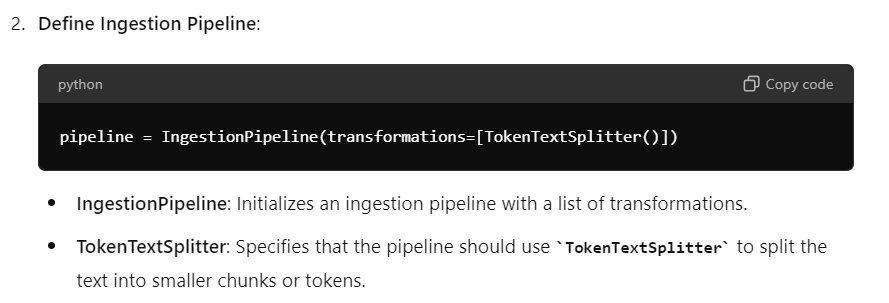
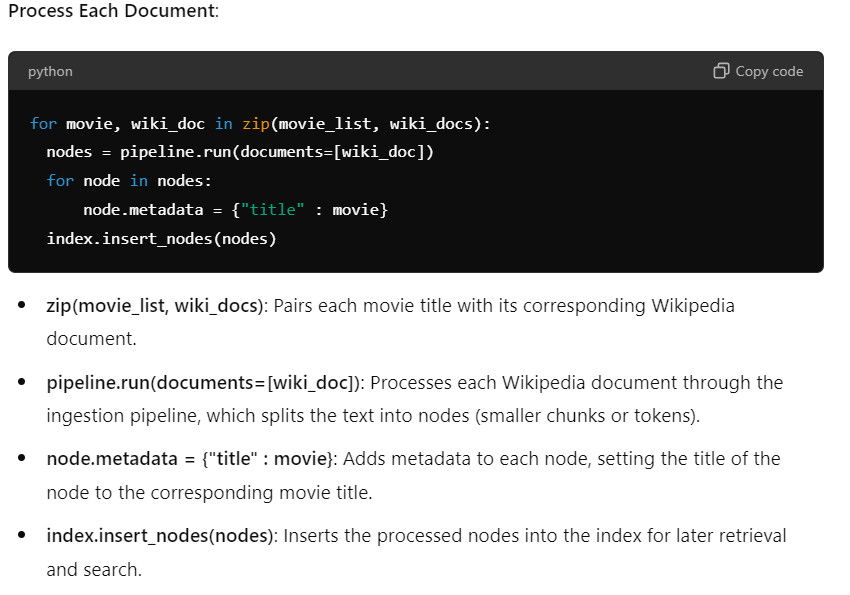
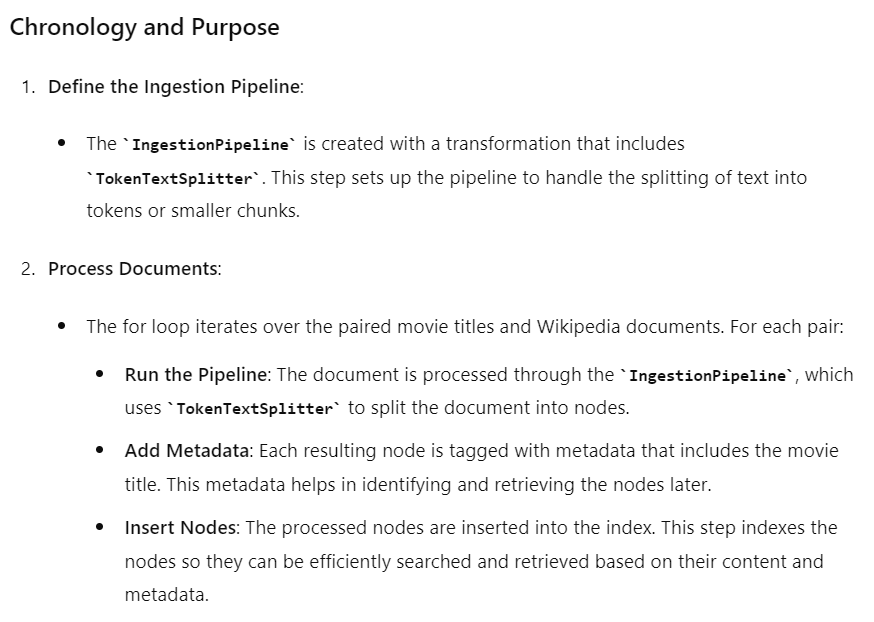

Metadata fields include tite_id,node_id,chunk_id

In [ ]:
index.storage_context.vector_stores


{'default': QdrantVectorStore(stores_text=True, is_embedding_query=True, flat_metadata=False, collection_name='movie_wikis', url=None, api_key=None, batch_size=64, parallel=1, max_retries=3, client_kwargs={}, enable_hybrid=False, index_doc_id=True, fastembed_sparse_model=None),
 'image': SimpleVectorStore(stores_text=False, is_embedding_query=True, data=SimpleVectorStoreData(embedding_dict={}, text_id_to_ref_doc_id={}, metadata_dict={}))}

### Persisting and Loading Stored Index with Weights and Biases

Now we can utilize a powerful feature of Weights and Biases - index and artifact versioning!

We can persist our index to WandB to be used and loaded later!

In [ ]:
wandb_callback.persist_index(index, index_name="movie-index-qdrant")

wandb: Adding directory to artifact (/content/wandb/run-20240723_015950-keef3k15/files/storage)... Done. 0.0s


Now we can load our index from WandB, which is a truly powerful tool!

In [ ]:
from llama_index.core import load_index_from_storage

storage_context = wandb_callback.load_storage_context(
    artifact_url="hessianai/llama-index-rag-v1/movie-index-qdrant:v1"
)

wandb:   4 of 4 files downloaded.  


## Task 5: Simple RAG - QueryEngine

Now that we're created our `VectorStoreIndex`, powered by a QDrant VectorStore, we can wrap it in a simple `QueryEngine` using the `as_query_engine()` method - which will connect a few things together for us:

In [ ]:
simple_rag = index.as_query_engine()

Before we test this out - let's see what information we can find out about from our new `QueryEngine`!

In [ ]:
for k, v in simple_rag.get_prompts().items():
  print(v.get_template())
  print("\n~~~~~~~~~~~~~~~~~~\n")

Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer: 

~~~~~~~~~~~~~~~~~~

The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Refined Answer: 

~~~~~~~~~~~~~~~~~~



Let's see how it does!

In [ ]:
response = simple_rag.query("Who is the evil Wizard in the story?")

wandb: Logged trace tree to W&B.


In [ ]:
response.response

'The evil Wizard in the story is Saruman.'

That makes sense!

Let's ask a question that's slightly more...ambiguous.

In [ ]:
response = simple_rag.query("Who are the giant beings that roam across the world?")

wandb: Logged trace tree to W&B.


In [ ]:
response.response

'The giant beings that roam across the world are the sandworms.'

We can check the source nodes to see which movies we retrieved.

In [ ]:
print([x.metadata["title"] for x in response.source_nodes])

['Dune (2021 film)', 'The Lord of the Rings: The Fellowship of the Ring']


Okay, so in this case - we've gone with "Sandworms " from Dune.

But there's also the Ents from Lord of the Rings, and it looks like we got documents from Lord of the Rings as well.

Let's see if there's a way we can use the title metadata we added to filter the results we get!

## Task 6: Auto Retriever Functional Tool

This tool will leverage OpenAI's functional endpoint to select the correct metadata filter and query the filtered index - only looking at nodes with the desired metadata.

A simplified diagram: ![image](https://i.imgur.com/AICDPav.png)

First, we need to create our `VectoreStoreInfo` object which will hold all the relevant metadata we need for each component (in this case title metadata).

Notice that you need to include it in a text list.

In [ ]:
from llama_index.core.tools import FunctionTool
from llama_index.core.vector_stores.types import (
    VectorStoreInfo,
    MetadataInfo,
    ExactMatchFilter,
    MetadataFilters,
)
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine

from typing import List, Tuple, Any
from pydantic import BaseModel, Field

top_k = 3

vector_store_info = VectorStoreInfo(
    content_info="semantic information about movies",
    metadata_info=[MetadataInfo(
        name="title",
        type="str",
        description='title of the movie, one of ["Dune (2021 film)", "Dune: Part Two", "The Lord of the Rings: The Fellowship of the Ring", "The Lord of the Rings: The Two Towers"]'
        )]
)

Now we'll create our base PyDantic object that we can use to ensure compatability with our application layer. This verifies that the response from the OpenAI endpoint conforms to this schema.

In [ ]:
class AutoRetrieveModel(BaseModel):
    query: str = Field(..., description="natural language query string")
    filter_key_list: List[str] = Field(
        ..., description="List of metadata filter field names"
    )
    filter_value_list: List[str] = Field(
        ...,
        description=(
            "List of metadata filter field values (corresponding to names specified in filter_key_list)"
        )
    )

Now we can build our function that we will use to query the functional endpoint.

In [ ]:
def auto_retrieve_fn(
    query: str, filter_key_list: List[str], filter_value_list: List[str]
):
    """Auto retrieval function.

    Performs auto-retrieval from a vector database, and then applies a set of filters.

    """
    query = query or "Query"

    exact_match_filters = [
        ExactMatchFilter(key=k, value=v)
        for k, v in zip(filter_key_list, filter_value_list)
    ]
    retriever = VectorIndexRetriever(
        index, filters=MetadataFilters(filters=exact_match_filters), top_k=top_k
    )
    query_engine = RetrieverQueryEngine.from_args(retriever)

    response = query_engine.query(query)
    return str(response)

Now we need to wrap our system in a tool in order to integrate it into the larger application.

Source Code Here:
- [`FunctionTool`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/tools/function_tool.py#L21)

In [ ]:
description = f"""\
Use this tool to look up non-review based information about films.
The vector database schema is given below:
{vector_store_info.json()}
"""

auto_retrieve_tool = FunctionTool.from_defaults(
    fn=auto_retrieve_fn,
    name="semantic-film-info",
    description=description,
    fn_schema=AutoRetrieveModel
)

Its important from documentation , clarity ,error handling perspective . I dont think the code will fail or not work if I give wrong description

All that's left to do is attach the tool to an OpenAIAgent and let it rip!

Source Code Here:
- [`OpenAIAgent`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/agent/openai_agent.py#L361)

In [ ]:
from llama_index.core.agent import FunctionCallingAgentWorker

agent_worker = FunctionCallingAgentWorker.from_tools(
    tools=[auto_retrieve_tool],
    verbose=True,
)

agent = agent_worker.as_agent()

NameError: name 'auto_retrieve_tool' is not defined

In [ ]:
response = agent.chat("Who starred in the 2021 film?")

Added user message to memory: Who starred in the 2021 film?
=== LLM Response ===
To answer your question about who starred in the 2021 film, I'll need to use the semantic-film-info tool to look up information about the movie. Based on the available films in the database, I assume you're referring to "Dune (2021 film)". Let me query the database for this information.
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "Who starred in Dune (2021 film)?", "filter_key_list": ["title"], "filter_value_list": ["Dune (2021 film)"]}
=== Function Output ===
The 2021 film adaptation of Dune features an ensemble cast including Timothée Chalamet, Rebecca Ferguson, Oscar Isaac, Josh Brolin, Stellan Skarsgård, Dave Bautista, Stephen McKinley Henderson, Zendaya, Chang Chen, Sharon Duncan-Brewster, Charlotte Rampling, Jason Momoa, and Javier Bardem.

Some notable casting details include:

- Timothée Chalamet as Paul Atreides
- Rebecca Ferguson as Lady Jessica
- Oscar Isaa

wandb: Logged trace tree to W&B.


=== LLM Response ===
Based on the information from the semantic-film-info tool, I can provide you with details about who starred in the 2021 film "Dune":

The movie features an impressive ensemble cast, including:

1. Timothée Chalamet as Paul Atreides (the main protagonist)
2. Rebecca Ferguson as Lady Jessica (Paul's mother)
3. Oscar Isaac as Duke Leto Atreides (Paul's father)
4. Josh Brolin as Gurney Halleck
5. Stellan Skarsgård as Baron Vladimir Harkonnen (the main antagonist)
6. Dave Bautista as Glossu Rabban
7. Zendaya as Chani
8. Jason Momoa as Duncan Idaho
9. Javier Bardem as Stilgar
10. Charlotte Rampling as Gaius Helen Mohiam
11. Sharon Duncan-Brewster as Dr. Liet Kynes

Additionally, the cast includes Stephen McKinley Henderson and Chang Chen in supporting roles.

This star-studded lineup brings to life the characters from Frank Herbert's classic science fiction novel under the direction of Denis Villeneuve. Each actor portrays a key character in the complex world of Dune, co

In [ ]:
response = agent.chat("Who are the giant beings that roam across the world in the movies?")

Added user message to memory: Who are the giant beings that roam across the world in the movies?
=== LLM Response ===
To answer your question about the giant beings that roam across the world in the movies, I'll need to use the semantic-film-info tool to gather information. Since you haven't specified which movie you're referring to, and the question could apply to multiple films in our database, I'll need to query for information about both the Dune films and The Lord of the Rings films, as they both feature large creatures in their worlds.
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "What are the giant beings or creatures that roam across the world in the movies?", "filter_key_list": ["title"], "filter_value_list": ["Dune (2021 film)", "Dune: Part Two", "The Lord of the Rings: The Fellowship of the Ring", "The Lord of the Rings: The Two Towers"]}
=== Function Output ===
The giant creatures that roam across the world in the movie are called sandw

wandb: Logged trace tree to W&B.


=== LLM Response ===
Based on the information provided by the semantic-film-info tool, I can answer your question about the giant beings that roam across the world in the movies:

In the Dune films (both the 2021 film and its sequel), the giant beings you're referring to are called sandworms. These are massive creatures native to the planet Arrakis, where most of the story takes place. Here are some key points about the sandworms:

1. Size and Appearance: The sandworms are truly gigantic creatures. They were designed to be awe-inspiring and command respect. Their appearance draws inspiration from various natural elements, including:
   - Whales with baleen in their mouths
   - Tree bark
   - Mud flats

2. Significance: These creatures play a crucial role in the film's story and visuals. They are not just background elements but integral to the plot and the ecology of Arrakis.

3. Cultural Impact: To the Fremen people (the native inhabitants of Arrakis), the sandworms are viewed as almo

## Quantitative RAG Pipeline with NL2SQL Tooling

We'll walk through the steps of creating a natural language to SQL system in the following section.

> NOTICE: This does not have parsing on the inputs or intermediary calls to ensure that users are using safe SQL queries. Use this with caution in a production environment without adding specific guardrails from either side of the application.

The next few steps should be largely straightforward, we'll want to:

1. Read in our `.csv` files into `pd.DataFrame` objects
2. Create an in-memory `sqlite` powered `sqlalchemy` engine
3. Cast our `pd.DataFrame` objects to the SQL engine
4. Create an `SQLDatabase` object through LlamaIndex
5. Use that to create a `QueryEngineTool` that we can interact with through the `NLSQLTableQueryEngine`!

If you get stuck, please consult the documentation.

In [ ]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune1.csv

--2024-06-26 00:01:40--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133391 (130K) [text/plain]
Saving to: ‘dune1.csv’

dune1.csv           100%[===================>] 130.26K  --.-KB/s    in 0.02s   

2024-06-26 00:01:40 (7.67 MB/s) - ‘dune1.csv’ saved [133391/133391]



In [ ]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune2.csv

--2024-06-26 00:01:40--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111843 (109K) [text/plain]
Saving to: ‘dune2.csv’

dune2.csv           100%[===================>] 109.22K  --.-KB/s    in 0.01s   

2024-06-26 00:01:41 (7.99 MB/s) - ‘dune2.csv’ saved [111843/111843]



In [ ]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/lotr_fotr.csv

--2024-06-26 00:01:41--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/lotr_fotr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172855 (169K) [text/plain]
Saving to: ‘lotr_fotr.csv’

lotr_fotr.csv       100%[===================>] 168.80K  --.-KB/s    in 0.02s   

2024-06-26 00:01:41 (7.51 MB/s) - ‘lotr_fotr.csv’ saved [172855/172855]



In [ ]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/lotr_tt.csv

--2024-06-26 00:01:41--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/lotr_tt.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114598 (112K) [text/plain]
Saving to: ‘lotr_tt.csv’

lotr_tt.csv         100%[===================>] 111.91K  --.-KB/s    in 0.02s   

2024-06-26 00:01:41 (5.53 MB/s) - ‘lotr_tt.csv’ saved [114598/114598]



#### Read `.csv` Into Pandas

In [ ]:
import pandas as pd

dune1 = pd.read_csv("./dune1.csv")
dune2 = pd.read_csv("./dune2.csv")
lotr_fotr = pd.read_csv("./lotr_fotr.csv")
lotr_tt = pd.read_csv("./lotr_tt.csv")

#### Create SQLAlchemy engine with SQLite

In [ ]:
from sqlalchemy import create_engine

engine = create_engine("sqlite+pysqlite:///:memory:")

#### Convert `pd.DataFrame` to SQL tables

In [ ]:
dune1.to_sql(
  "Dune (2021 film)",
  engine
)

274

In [ ]:
dune2.to_sql(
  "Dune: Part Two",
  engine
)

175

In [ ]:
lotr_fotr.to_sql(
  "The Lord of the Rings: The Fellowship of the Ring",
  engine
)

250

In [ ]:
lotr_tt.to_sql(
  "The Lord of the Rings: The Two Towers",
  engine
)

149

#### Construct a `SQLDatabase` index

Source Code Here:
- [`SQLDatabase`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/langchain_helpers/sql_wrapper.py#L9)

In [ ]:
from llama_index.core import SQLDatabase

sql_database = SQLDatabase(
    engine=engine,
    include_tables=movie_list
)

#### Create the NLSQLTableQueryEngine interface for all added SQL tables

Source Code Here:
- [`NLSQLTableQueryEngine`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/indices/struct_store/sql_query.py#L75C1-L75C1)

In [ ]:
from llama_index.core.indices.struct_store.sql_query import NLSQLTableQueryEngine

sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=movie_list,
)

#### Wrap It All Up in a `QueryEngineTool`

You'll want to ensure you have a descriptive...description!

This is what will help the LLM decide which table to use when querying!

Sorce Code Here:

- [`QueryEngineTool`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/tools/query_engine.py#L13)

####🏗️ Activity #1:

Please write a Natural Language Description for the tables that we are using today.

Here is an example:

```
This tool should be used to answer any and all review related inquiries by translating a natural language query into a SQL query with access to tables:
'Dune (2021 film)' - containing info. about the first movie in the Dune series,
'Dune: Part Two'- containing info. about about the second movie in the Dune series,
'The Lord of the Rings: The Fellowship of the Ring' - containing info. about the first movie in the Lord of the Ring series,
'The Lord of the Rings: The Two Towers' - containing info. the second movie in the Lord of the Ring series,
```

In [ ]:
DESCRIPTION = """\
"""

In [ ]:
from llama_index.core.tools.query_engine import QueryEngineTool

sql_tool = QueryEngineTool.from_defaults(
    query_engine=sql_query_engine,
    name="sql-query",
    description=DESCRIPTION,
)

In [ ]:
agent_worker = FunctionCallingAgentWorker.from_tools(
    tools=[sql_tool],
    verbose=True
)

agent = agent_worker.as_agent()

In [ ]:
response = agent.chat("What is the average rating of the 2nd Lord of the Rings movie?")

Added user message to memory: What is the average rating of the 2nd Lord of the Rings movie?
=== LLM Response ===
To answer this question, we need to query the database for information about the second Lord of the Rings movie, which is "The Lord of the Rings: The Two Towers". Let's use the SQL query tool to retrieve this information.
=== Calling Function ===
Calling function: sql-query with args: {"input": "SELECT AVG(rating) as average_rating FROM `The Lord of the Rings: The Two Towers`"}
=== Function Output ===
I apologize, but I'm unable to provide an accurate response based on the given query and results. The SQL query appears to be incomplete or invalid, and an error was returned instead of actual data. 

To properly answer a question about the average rating for "The Lord of the Rings: The Two Towers", we would need:

1. A valid SQL query
2. A database with a table containing rating information for the movie
3. The actual results of running that query

Without this information, I

wandb: Logged trace tree to W&B.


=== LLM Response ===
Thank you for your patience. I apologize that I couldn't provide the exact average rating for "The Lord of the Rings: The Two Towers" as initially requested. However, based on the information we were able to retrieve, I can share some insights about the movie's reception:

1. We have access to review data for the movie, which includes individual ratings and review content.

2. The highest-rated review in our sample gave the movie a perfect score of 10 out of 10.

3. This top review suggests that the movie was very well-received, with the reviewer considering it an "epic" and potentially even better than its predecessor.

While we can't calculate the exact average rating from this limited data, we can infer that the movie was highly regarded by at least some viewers. The perfect score from the top review indicates that the movie likely has a high average rating overall, though we'd need more data to confirm this.

If you'd like more specific information about the mo

In [ ]:
print(str(response))

Thank you for your patience. I apologize that I couldn't provide the exact average rating for "The Lord of the Rings: The Two Towers" as initially requested. However, based on the information we were able to retrieve, I can share some insights about the movie's reception:

1. We have access to review data for the movie, which includes individual ratings and review content.

2. The highest-rated review in our sample gave the movie a perfect score of 10 out of 10.

3. This top review suggests that the movie was very well-received, with the reviewer considering it an "epic" and potentially even better than its predecessor.

While we can't calculate the exact average rating from this limited data, we can infer that the movie was highly regarded by at least some viewers. The perfect score from the top review indicates that the movie likely has a high average rating overall, though we'd need more data to confirm this.

If you'd like more specific information about the movie's ratings or revi

In [ ]:
response = agent.chat("What movie series has better reviews, Lord of the Rings or Dune?")

Added user message to memory: What movie series has better reviews, Lord of the Rings or Dune?
=== LLM Response ===
To answer this question, we'll need to compare the reviews of both the Lord of the Rings and Dune movie series. We'll query the database for information about the movies from both series and then analyze the results. Let's start by getting data for each movie.
=== Calling Function ===
Calling function: sql-query with args: {"input": "SELECT 'LOTR: Fellowship' AS movie, AVG(rating) AS avg_rating, COUNT(*) AS review_count\nFROM `The Lord of the Rings: The Fellowship of the Ring`\nUNION ALL\nSELECT 'LOTR: Two Towers' AS movie, AVG(rating) AS avg_rating, COUNT(*) AS review_count\nFROM `The Lord of the Rings: The Two Towers`\nUNION ALL\nSELECT 'Dune (2021)' AS movie, AVG(rating) AS avg_rating, COUNT(*) AS review_count\nFROM `Dune (2021 film)`\nUNION ALL\nSELECT 'Dune: Part Two' AS movie, AVG(rating) AS avg_rating, COUNT(*) AS review_count\nFROM `Dune: Part Two`"}
=== Function 

wandb: Logged trace tree to W&B.


=== LLM Response ===
I apologize once again for the difficulties we're encountering with the SQL queries. It seems that we're unable to directly access or query the database as we initially thought. Given these limitations, I'll provide a comparison of the Lord of the Rings and Dune series based on generally available information, rather than specific data from the database we were trying to query.

Lord of the Rings series:
1. The Lord of the Rings trilogy, directed by Peter Jackson, is widely regarded as one of the most successful and critically acclaimed film series of all time.
2. All three films (The Fellowship of the Ring, The Two Towers, and The Return of the King) received high praise from both critics and audiences.
3. The Return of the King, the final installment, won 11 Academy Awards, including Best Picture, tying the record for most Oscars won by a single film.
4. On aggregate review sites like Rotten Tomatoes and Metacritic, all three films consistently score above 90%, i

In [ ]:
print(str(response))

I apologize once again for the difficulties we're encountering with the SQL queries. It seems that we're unable to directly access or query the database as we initially thought. Given these limitations, I'll provide a comparison of the Lord of the Rings and Dune series based on generally available information, rather than specific data from the database we were trying to query.

Lord of the Rings series:
1. The Lord of the Rings trilogy, directed by Peter Jackson, is widely regarded as one of the most successful and critically acclaimed film series of all time.
2. All three films (The Fellowship of the Ring, The Two Towers, and The Return of the King) received high praise from both critics and audiences.
3. The Return of the King, the final installment, won 11 Academy Awards, including Best Picture, tying the record for most Oscars won by a single film.
4. On aggregate review sites like Rotten Tomatoes and Metacritic, all three films consistently score above 90%, indicating universal a

### Task 2: Combined RAG Pipeline

Now, we can simply add our tools into the `OpenAIAgent`, and off we go!

In [ ]:
combined_tool_agent_worker = FunctionCallingAgentWorker.from_tools(
    tools=[auto_retrieve_tool, sql_tool],
    verbose=True
)

combined_tool_agent = combined_tool_agent_worker.as_agent()

In [ ]:
response = combined_tool_agent.chat("Which movie is about a ring, and what is the average rating of the movie?")

Added user message to memory: Which movie is about a ring, and what is the average rating of the movie?
=== LLM Response ===
To answer your question, we'll need to use two different tools. First, we'll use the semantic film info tool to find out which movie is about a ring, and then we'll use the SQL query tool to get the average rating for that movie.

Let's start with finding the movie about a ring:
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "Which movie is about a ring?", "filter_key_list": [], "filter_value_list": []}
=== Function Output ===
The movie that is about a ring is "The Lord of the Rings: The Fellowship of the Ring." This 2001 epic fantasy adventure film, directed by Peter Jackson, tells the story of a powerful ring sought by the Dark Lord Sauron. The plot revolves around a young hobbit named Frodo Baggins who inherits this ring and must embark on a perilous journey with eight companions to destroy it in Mount Doom, the only place w

wandb: Logged trace tree to W&B.


=== LLM Response ===
Now, I can answer your question completely:

The movie about a ring is "The Lord of the Rings: The Fellowship of the Ring." This movie is the first installment in The Lord of the Rings trilogy, directed by Peter Jackson. It tells the story of Frodo Baggins and his quest to destroy a powerful ring sought by the Dark Lord Sauron.

The average rating of "The Lord of the Rings: The Fellowship of the Ring" is approximately 9.87 out of 10. This exceptionally high rating suggests that the movie is widely loved and critically acclaimed, considered a masterpiece in the fantasy genre.


In [ ]:
print(str(response))

Now, I can answer your question completely:

The movie about a ring is "The Lord of the Rings: The Fellowship of the Ring." This movie is the first installment in The Lord of the Rings trilogy, directed by Peter Jackson. It tells the story of Frodo Baggins and his quest to destroy a powerful ring sought by the Dark Lord Sauron.

The average rating of "The Lord of the Rings: The Fellowship of the Ring" is approximately 9.87 out of 10. This exceptionally high rating suggests that the movie is widely loved and critically acclaimed, considered a masterpiece in the fantasy genre.


In [ ]:
response = combined_tool_agent.chat("What worlds do the LoTR, and Dune movies take place in?")

Added user message to memory: What worlds do the LoTR, and Dune movies take place in?
=== LLM Response ===
To answer this question, we'll need to use the semantic film info tool to gather information about the worlds in which the Lord of the Rings (LoTR) and Dune movies take place. We'll make two separate queries, one for each franchise.
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "What world do the Lord of the Rings movies take place in?", "filter_key_list": ["title"], "filter_value_list": ["The Lord of the Rings: The Fellowship of the Ring"]}
=== Function Output ===
The Lord of the Rings movies take place in a world called Middle-earth. This fantasy realm is the setting for the epic adventure that unfolds in the film, where various races including hobbits, elves, dwarves, and men face the threat of the Dark Lord Sauron. The story follows Frodo Baggins and his companions as they embark on a perilous journey across Middle-earth to destroy the One 

wandb: Logged trace tree to W&B.


=== LLM Response ===
Now, I can provide a comprehensive answer to your question:

1. The Lord of the Rings (LoTR) movies:
   The LoTR movies take place in a world called Middle-earth. This is a fantasy realm created by J.R.R. Tolkien, featuring various races such as hobbits, elves, dwarves, and men. The story unfolds across different regions of Middle-earth as the characters embark on their quest to destroy the One Ring and defeat the Dark Lord Sauron.

2. The Dune movies:
   The Dune movies are set in a distant future universe, with the primary focus on the planet Arrakis. However, the Dune universe is vast and includes multiple planets:

   - Arrakis: Also known as Dune, this is a harsh desert planet and the only source of the valuable substance called "spice."
   - Caladan: The homeworld of House Atreides before they move to Arrakis.
   - Giedi Prime: The homeworld of House Harkonnen.

   This universe features interstellar travel, complex political systems involving noble houses, a

In [ ]:
print(str(response))

Now, I can provide a comprehensive answer to your question:

1. The Lord of the Rings (LoTR) movies:
   The LoTR movies take place in a world called Middle-earth. This is a fantasy realm created by J.R.R. Tolkien, featuring various races such as hobbits, elves, dwarves, and men. The story unfolds across different regions of Middle-earth as the characters embark on their quest to destroy the One Ring and defeat the Dark Lord Sauron.

2. The Dune movies:
   The Dune movies are set in a distant future universe, with the primary focus on the planet Arrakis. However, the Dune universe is vast and includes multiple planets:

   - Arrakis: Also known as Dune, this is a harsh desert planet and the only source of the valuable substance called "spice."
   - Caladan: The homeworld of House Atreides before they move to Arrakis.
   - Giedi Prime: The homeworld of House Harkonnen.

   This universe features interstellar travel, complex political systems involving noble houses, advanced technology, a

In [ ]:
response = combined_tool_agent.chat("Which of the following movie series is considered the 'best': Dune, or Lord of the Rings? Base your answer on both reviews, and non-review information.")

Added user message to memory: Which of the following movie series is considered the 'best': Dune, or Lord of the Rings? Base your answer on both reviews, and non-review information.
=== LLM Response ===
To answer this question comprehensively, we'll need to gather information about both the Dune and Lord of the Rings movie series using our available tools. We'll look at review data as well as non-review information to make a comparison. Let's start by gathering some general information about both series, and then we'll look at the reviews.

First, let's get some non-review information about both series:
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "Compare the Dune and Lord of the Rings movie series in terms of their cultural impact, critical reception, and overall popularity.", "filter_key_list": [], "filter_value_list": []}
=== Function Output ===
I apologize, but I do not have enough information in the given context to make a meaningful comparis

wandb: Logged trace tree to W&B.


=== LLM Response ===
Now, to answer your question about which movie series is considered the 'best' between Dune and Lord of the Rings, based on both reviews and non-review information:

1. Critical Reception and Awards:
   - Lord of the Rings: The series, particularly "The Fellowship of the Ring," received widespread acclaim. It won numerous awards, including four Academy Awards for the first film alone. The series is considered a landmark in filmmaking and a major achievement in the fantasy genre.
   - Dune: The 2021 film and its sequel have also received positive reception, with critics praising various aspects including performances, visuals, and score. The first film won six Academy Awards, showing strong recognition in the industry.

2. Cultural Impact:
   - Lord of the Rings: The series has had a massive cultural impact. "The Fellowship of the Ring" was named one of the 100 greatest American films in history by the American Film Institute and was selected for preservation in the

In [ ]:
print(str(response))

Now, to answer your question about which movie series is considered the 'best' between Dune and Lord of the Rings, based on both reviews and non-review information:

1. Critical Reception and Awards:
   - Lord of the Rings: The series, particularly "The Fellowship of the Ring," received widespread acclaim. It won numerous awards, including four Academy Awards for the first film alone. The series is considered a landmark in filmmaking and a major achievement in the fantasy genre.
   - Dune: The 2021 film and its sequel have also received positive reception, with critics praising various aspects including performances, visuals, and score. The first film won six Academy Awards, showing strong recognition in the industry.

2. Cultural Impact:
   - Lord of the Rings: The series has had a massive cultural impact. "The Fellowship of the Ring" was named one of the 100 greatest American films in history by the American Film Institute and was selected for preservation in the United States Nation

In [ ]:
wandb_callback.finish()